In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian import interpolate, grids, misc, estimation   # modules

# Household heterogeneous block
def household_guess(a_grid, r, z_grid, gamma, T, tauc):
    new_z = np.ones((z_grid.shape[0],1))
    wel = (1 + r) * a_grid[np.newaxis,:] + new_z + T[:,np.newaxis]
    V_prime = (1 + r) / (1 + tauc) * (wel * 0.1) ** (-gamma) # check
    return V_prime

@het(exogenous = 'Pi',policy = 'a', backward = 'V_prime', backward_init = household_guess)
def household(V_prime_p, a_grid, z_grid, e_grid, r, T, beta, gamma, tauc):

    c_prime = (beta * (1 + tauc) * V_prime_p) ** (-1/gamma) # c_prime is the new guess for c_t
    new_grid = (1 + tauc) * c_prime + a_grid[np.newaxis,:] - z_grid[:,np.newaxis] - T[:,np.newaxis]
    wel = (1 + r) * a_grid
    c = interpolate.interpolate_y(new_grid,wel,c_prime)
    a = wel + z_grid[:,np.newaxis] + T[:,np.newaxis] - (1 + tauc) * c
    V_prime = (1 + r) / (1 + tauc) * c ** (-gamma) # check

    # Check for violation of the asset constraint and fix it
    indexes_asset = np.nonzero(a < a_grid[0]) # first dimension: labor grid, second dimension: asset grid
    if indexes_asset[0].size != 0 and indexes_asset[1].size !=0:  
        a[indexes_asset] = a_grid[0]
        c[indexes_asset] = (wel[indexes_asset[1]] + z_grid[indexes_asset[0]] 
                            + T[indexes_asset[0]] - a[indexes_asset]) / (1 + tauc)
        V_prime[indexes_asset] = (1 + r) / (1 + tauc) * (c[indexes_asset]) ** (-gamma) # check
    uce = e_grid[:,np.newaxis] * c ** (-gamma)
    return V_prime, a, c, uce

print(household)
print(f'Inputs: {household.inputs}')
print(f'Macro outputs: {household.outputs}')
print(f'Micro outputs: {household.internals}')

def income(e_grid, w, N, taun):
    z_grid = (1 - taun) * w * N * e_grid
    return z_grid

def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, pi_e, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    return e_grid, Pi, a_grid, pi_e

def transfers(pi_e, Div, Transfer, e_grid):
    # hardwired incidence rules are proportional to skill; scale does not matter 
    tax_rule, div_rule = np.ones(e_grid.size), e_grid #np.ones(e_grid.size)
    div = Div / np.sum(pi_e * div_rule) * div_rule
    transfer =  (Transfer) / np.sum(pi_e * tax_rule) * tax_rule 
    T = div + transfer
    return T

hh_inp = household.add_hetinputs([make_grid,transfers,income])

print(hh_inp)
print(f'Inputs: {hh_inp.inputs}')
print(f'Outputs: {hh_inp.outputs}')

<HetBlock 'household'>
Inputs: ['a_grid', 'z_grid', 'e_grid', 'r', 'T', 'beta', 'gamma', 'tauc', 'Pi']
Macro outputs: ['A', 'C', 'UCE']
Micro outputs: ['D', 'Dbeg', 'Pi', 'V_prime', 'a', 'c', 'uce']
<HetBlock 'household' with hetinput 'make_grid_transfers'>
Inputs: ['r', 'beta', 'gamma', 'tauc', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Div', 'Transfer', 'w', 'N', 'taun']
Outputs: ['A', 'C', 'UCE']


In [2]:
@simple
def firm(Y, w, Z, pi, mu, kappa):
    N = Y / Z
    Div = Y - w * N - mu / (mu - 1) / (2 * kappa) * (1 + pi).apply(np.log) ** 2 * Y
    return Div, N

@simple
def monetary(pi, rstar, phi_pi):
    r = (1 + rstar(-1) + phi_pi * pi(-1)) / (1 + pi) - 1
    i = rstar
    return r, i

@simple
def fiscal(r, Transfer, B, C, N, tauc, taun, w):
    govt_res = Transfer + (1 + r) * B(-1) - tauc * C - taun * w * N - B
    Deficit = Transfer - tauc * C - taun * w * N # primary deficit
    Trans = Transfer
    return govt_res, Deficit, Trans

@simple
def mkt_clearing(A, C, Y, B, pi, mu, kappa):
    asset_mkt = A - B
    goods_mkt = Y - C - mu / (mu - 1) / (2 * kappa) * (1 + pi).apply(np.log) ** 2 * Y
    return asset_mkt, goods_mkt

@simple
def nkpc_ss(Z, mu):
    w = Z / mu
    return w

@simple 
def union_ss(w, N, UCE, kappaw, nu, muw, tauc, taun):
    phi = ((1 - taun) * w * N ** (-nu) * UCE) / ((1 + tauc) * muw) # our formula
    wnkpc = kappaw * (phi * N ** (1 + nu) - (1 - taun) * w * N * UCE / ((1 + tauc) * muw))
    return wnkpc, phi

@simple 
def auclert_union_ss(w, N, UCE, kappaw, nu, muw, tauc, taun):
    phi = (w * UCE) / (muw * N ** (1 + nu)) # our formula
    wnkpc = kappaw * (phi * N ** (1 + nu) - w / muw * UCE)
    return wnkpc, phi

blocks_ss = [hh_inp, firm, monetary, fiscal, mkt_clearing, nkpc_ss, union_ss]

hank_ss = create_model(blocks_ss, name = "One-Asset HANK SS")

print(hank_ss)
print(f"Inputs: {hank_ss.inputs}")

<Model 'One-Asset HANK SS'>
Inputs: ['beta', 'gamma', 'tauc', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Transfer', 'taun', 'Y', 'Z', 'pi', 'mu', 'kappa', 'rstar', 'phi_pi', 'B', 'kappaw', 'nu', 'muw']


In [3]:
calibration = {'gamma': 1.0, 'nu': 2.0, 'rho_e': 0.966, 'sd_e': 0.5, 'nE': 7,
               'amin': 0, 'amax': 150, 'nA': 500, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
               'mu': 1.2, 'kappa': 0.1, 'rstar': 0.005, 'phi_pi': 0.0, 'B': 6.0,
               'kappaw': 0.005, 'muw': 1.1, 'N': 1.0, 'tauc': 0.1, 'taun': 0.036}

unknowns_ss = {'beta': 0.986, 'Transfer': -0.03}
targets_ss = {'asset_mkt': 0, 'govt_res': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")

In [4]:
@simple
def wage(pi, w):
    piw = (1 + pi) * w / w(-1) - 1
    return piw

@simple
def union(piw, w, N, UCE, kappaw, phi, nu, muw, beta, tauc, taun):
    wnkpc = (kappaw * (phi * N ** (1+nu) - (1 - taun) * w * N * UCE / ((1 + tauc) * muw)) 
             + beta * (1 + piw(+1)).apply(np.log) - (1 + piw).apply(np.log))
    return wnkpc

@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
               - (1 + pi).apply(np.log)
    return nkpc_res

blocks = [hh_inp, firm, monetary, fiscal, mkt_clearing, nkpc,wage,union]
hank = create_model(blocks, name = "One-Asset HANK")

ss = hank.steady_state(ss0)

for k in ss0.keys():
    assert np.all(np.isclose(ss[k], ss0[k]))
    
T = 300
exogenous = ['rstar','Transfer', 'Z', 'tauc']
unknowns = ['pi', 'w', 'Y', 'B']
targets = ['nkpc_res', 'asset_mkt', 'wnkpc', 'govt_res']

# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)
#print(G)

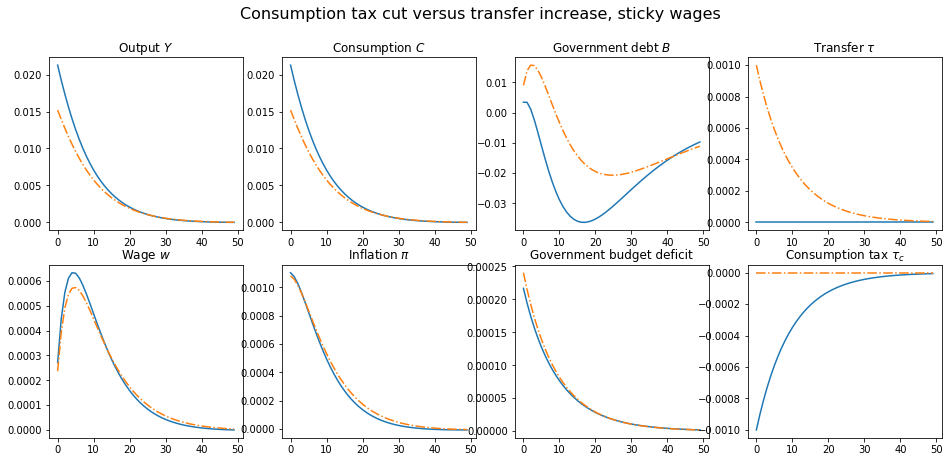

--------------------------------------------------
DIFFERENCE τc vs τ   IMPACT RATIO   CUMULATIVE SUM
--------------------------------------------------
Shocks                  1.000                0.000
Output                  1.401                0.042
Consumption             1.401                0.042
Inflation               1.021               -0.001
Wage                    1.145                0.000
Deficit                 0.901               -0.005
-------------------------------------------------------------------------
PARAMETERS
Discount factor                0.990   Intertemporal elasticity     1.000
Labor supply elasticity        0.500   Labor supply disutility      0.643
Goods substitutability         6.000   Price markup                 1.200
Labor substitutability        11.000   Wage markup                  1.100
Price Phillips slope           0.100   Taylor rule inflation        0.000
Wage Phillips slope            0.005   Taylor rule output           0.000
Consumption 

In [6]:
# Impulse response functions
rhos = 0.9
drstar = -0.02 * rhos ** (np.arange(T)[:, np.newaxis])
dtstar = 0.01 * rhos ** (np.arange(T)[:, np.newaxis])
dtauc = - 0.01 * rhos ** (np.arange(T)[:, np.newaxis])

dY = [G['Y']['rstar'] @ drstar, G['Y']['tauc'] @ dtauc, G['Y']['Transfer'] @ dtstar]
dC = [G['C']['rstar'] @ drstar, G['C']['tauc'] @ dtauc, G['C']['Transfer'] @ dtstar]
dN = [G['N']['rstar'] @ drstar, G['N']['tauc'] @ dtauc, G['N']['Transfer'] @ dtstar]
dB = [G['A']['rstar'] @ drstar, G['A']['tauc'] @ dtauc, G['A']['Transfer'] @ dtstar]
dw = [G['w']['rstar'] @ drstar, G['w']['tauc'] @ dtauc, G['w']['Transfer'] @ dtstar]
dp = [G['pi']['rstar'] @ drstar, G['pi']['tauc'] @ dtauc, G['pi']['Transfer'] @ dtstar]
dr = [G['r']['rstar'] @ drstar, G['r']['tauc'] @ dtauc, G['r']['Transfer'] @ dtstar]
dD = [G['Deficit']['rstar'] @ drstar, G['Deficit']['tauc'] @ dtauc, G['Deficit']['Transfer'] @ dtstar]
dd = [G['Div']['rstar'] @ drstar, G['Div']['tauc'] @ dtauc, G['Div']['Transfer'] @ dtstar]
dT = [np.zeros(T), np.zeros(T), G['Trans']['Transfer'] @ dtstar]
di = [G['i']['rstar'] @ drstar, np.zeros(T), np.zeros(T)]

plt.rcParams["figure.figsize"] = (16,7)
fig, ax = plt.subplots(2, 4)
fig.suptitle('Consumption tax cut versus transfer increase, sticky wages', size=16)

ax[0, 0].set_title(r'Output $Y$')
#l1, = ax[0, 0].plot(dY[0][:50, :])
l1, = ax[0, 0].plot(dY[1][:50, :] * ss0['Y'])
l2, = ax[0, 0].plot(dY[2][:50, :] * ss0['Y'],'-.')

ax[0, 1].set_title(r'Consumption $C$')
#ax[0, 1].plot(dC[0][:50, :])
ax[0, 1].plot(dC[1][:50, :] * ss0['C'])
ax[0, 1].plot(dC[2][:50, :] * ss0['C'],'-.')

ax[0, 2].set_title(r'Government debt $B$')
#ax[0, 2].plot(dB[0][:50, :])
ax[0, 2].plot(dB[1][:50, :] * ss0['A'])
ax[0, 2].plot(dB[2][:50, :] * ss0['A'],'-.')

ax[0, 3].set_title(r'Transfer $\tau$')
ax[0, 3].plot(np.zeros(50))
ax[0, 3].plot(dT[2][:50, :] * ss0['Trans'],'-.')

ax[1, 0].set_title(r'Wage $w$')
#ax[1, 0].plot(dw[0][:50, :])
ax[1, 0].plot(dw[1][:50, :] * ss0['w'])
ax[1, 0].plot(dw[2][:50, :] * ss0['w'],'-.')

ax[1, 1].set_title(r'Inflation $\pi$')
#ax[1, 1].plot(dp[0][:50, :])
ax[1, 1].plot(dp[1][:50, :])
ax[1, 1].plot(dp[2][:50, :],'-.')

#ax[1, 2].set_title(r'Real interest rate $r$')
#ax[1, 2].plot(dr[0][:50, :])
#ax[1, 2].plot(dr[1][:50, :])
#ax[1, 2].plot(dr[2][:50, :],'-.')

ax[1, 2].set_title(r'Government budget deficit')
#ax[1, 2].plot(dD[0][:50, :])
ax[1, 2].plot(-dD[1][:50, :] * ss0['Deficit'])
ax[1, 2].plot(-dD[2][:50, :] * ss0['Deficit'],'-.')

ax[1, 3].set_title(r'Consumption tax $\tau_c$')
ax[1, 3].plot(dtauc[:50] * ss0['tauc'])
ax[1, 3].plot(np.zeros(50),'-.')
plt.show()

# Difference consumption tax vs transfers
dif = [['DIFFERENCE \u03C4c vs \u03C4','IMPACT RATIO','CUMULATIVE SUM'],
      ['Shocks',np.ndarray.item(- (dtauc[:1] * ss0['tauc']) / (dT[2][:1, :] * ss0['Trans'])), - np.sum(dtauc) - np.sum(dT[2][:300])],
      ['Output',np.ndarray.item(dY[1][:1, :] / dY[2][:1, :]), np.sum(dY[1][:300, :]) - np.sum(dY[2][:300, :])],
      ['Consumption',np.ndarray.item(dC[1][:1, :] / dC[2][:1, :]), np.sum(dC[1][:300, :]) - np.sum(dC[2][:300, :])],
      ['Inflation',np.ndarray.item(dp[1][:1, :] / dp[2][:1, :]), np.sum(dp[1][:300, :]) - np.sum(dp[2][:300, :])],
      ['Wage',np.ndarray.item(dw[1][:1, :] / dw[2][:1, :]), np.sum(dw[1][:300, :]) - np.sum(dw[2][:300, :])],
      ['Deficit',np.ndarray.item(dD[1][:1, :] / dD[2][:1, :]), np.sum(dD[1][:300, :]) - np.sum(dD[2][:300, :])]]
dash = '-' * 50
for i in range(len(dif)):
    if i == 0:
        print(dash)
        print('{:<20s} {:^12s}  {:>15s}'.format(dif[i][0],dif[i][1],dif[i][2]))
        print(dash)
    else:
        print('{:<20s} {:^12.3f}  {:>15.3f}'.format(dif[i][0],dif[i][1],dif[i][2]))
        
# Show steady state
ss_param = [['Discount factor', ss0['beta'], 'Intertemporal elasticity', ss0['gamma']],
        ['Labor supply elasticity', 1 / ss0['nu'], 'Labor supply disutility', ss0['phi']],  
        ['Goods substitutability', ss0['mu'] / (ss0['mu'] - 1) , 'Price markup', ss0['mu']],
        ['Labor substitutability', ss0['muw'] / (ss0['muw'] - 1) , 'Wage markup', ss0['muw']],
        ['Price Phillips slope', ss0['kappa'], 'Taylor rule inflation ', ss0['phi_pi']],
        ['Wage Phillips slope', ss0['kappaw'], 'Taylor rule output ', 0],
        ['Consumption tax rate', ss0['tauc'], 'Labor tax rate', ss0['taun']]]

ss_var = [['Output', ss0['Y'], 'Government debt', ss0['A']],
        ['Consumption', ss0['C'], 'Transfers', ss0['Transfer']],
        ['Hours', ss0['N'], 'Dividends', ss0['Div']], 
        ['Wage', ss0['w'], 'Marginal cost', ss0['w'] / ss0['Z']],
        ['Inflation', ss0['pi'], 'Consumption tax revenue', ss0['tauc'] * ss0['C']],
        ['Nominal interest rate', ss0['r']*(1+ss0['pi']), 'Labor tax revenue', ss0['taun']*ss0['N']*ss0['w']],
        ['Real interest rate', ss0['r'], 'Debt servicing  cost', ss0['r'] * ss0['A']]]
ss_mkt = [['Bond market', ss0['asset_mkt'], 'Goods market (resid)', ss0['goods_mkt']],
          ['Government budget', ss0['govt_res'], '', float('nan')]]

dash = '-' * 73
print(dash)
print('PARAMETERS')
for i in range(len(ss_param)):
      print('{:<24s}{:>12.3f}   {:24s}{:>10.3f}'.format(ss_param[i][0],ss_param[i][1],ss_param[i][2],ss_param[i][3]))
print('\nVARIABLES')
for i in range(len(ss_var)):
      print('{:<24s}{:>12.3f}   {:24s}{:>10.3f}'.format(ss_var[i][0],ss_var[i][1],ss_var[i][2],ss_var[i][3]))
print('\nMARKET CLEARING')
for i in range(len(ss_mkt)):
      print('{:<24s}{:>12.0e}   {:24s}{:>10.0e}'.format(ss_mkt[i][0],ss_mkt[i][1],ss_mkt[i][2],ss_mkt[i][3]))
print(dash)        